# Import

In [1]:
import random 
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow_addons.metrics
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tqdm.auto import tqdm


import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

import seaborn as sns


from numpy import dot
from numpy.linalg import norm

Init Plugin
Init Graph Optimizer
Init Kernel


/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as

# Hyperparameter Setting

In [2]:
EPOCHS = 400
LR = 1e-2
BATCH_SIZE=10000
SEED = 42
LABELS = ["Normal", "Fraud"]

# Fixed Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Load Data

In [4]:
train_df = pd.read_csv('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/data/train.csv')
train_df = train_df.drop(columns=['ID'])

val_df = pd.read_csv('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/data/val.csv')
val_df = val_df.drop(columns=['ID'])

# AutoEncdoer

In [5]:

class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU()
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(30)
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Train

## GPU

In [6]:
print('GPU 여부: ', len(tf.config.list_logical_devices('GPU'))>0)

if tf.config.list_logical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name='/CPU:0'
print(device_name)

GPU 여부:  True
/device:GPU:0
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [7]:
train_df = pd.read_csv('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/data/train.csv')
train_df = train_df.drop(columns=['ID'])

val_df = pd.read_csv('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/data/val.csv')
val_df = val_df.drop(columns=['ID'])

In [8]:
X_train = train_df.values

X_val = val_df.drop(columns=['Class']).values
y_val = val_df['Class'].values

In [9]:
model = AutoEncoder()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics=['accuracy']
)

callback_list = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='auto', factor=0.5, patience=5, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/My_code/save_model/model.tf', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
]

strategy = tf.distribute.MirroredStrategy()


history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    callbacks=callback_list,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1).history

Epoch 1/400
12/12 [==============================] - 1s 74ms/step - loss: 0.4676 - accuracy: 0.4801 - val_loss: 0.3938 - val_accuracy: 0.5878
Epoch 2/400
12/12 [==============================] - 0s 32ms/step - loss: 0.2337 - accuracy: 0.7685 - val_loss: 0.4422 - val_accuracy: 0.7196
Epoch 3/400
12/12 [==============================] - 1s 39ms/step - loss: 0.1747 - accuracy: 0.8419 - val_loss: 0.4439 - val_accuracy: 0.7882
Epoch 4/400
12/12 [==============================] - 0s 32ms/step - loss: 0.1432 - accuracy: 0.8692 - val_loss: 0.4435 - val_accuracy: 0.7985
Epoch 5/400
12/12 [==============================] - 0s 33ms/step - loss: 0.1266 - accuracy: 0.8791 - val_loss: 0.4494 - val_accuracy: 0.8071
Epoch 6/400
12/12 [==============================] - 0s 32ms/step - loss: 0.1154 - accuracy: 0.8911 - val_loss: 0.4224 - val_accuracy: 0.8086

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 7/400
12/12 [==============================] - 0s 32ms/step - 

# Evaluate

In [10]:
autoencoder = tf.keras.models.load_model('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/My_code/save_model/model.tf')

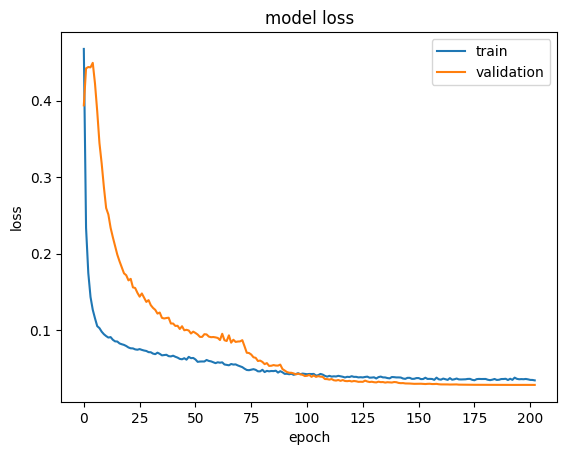

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

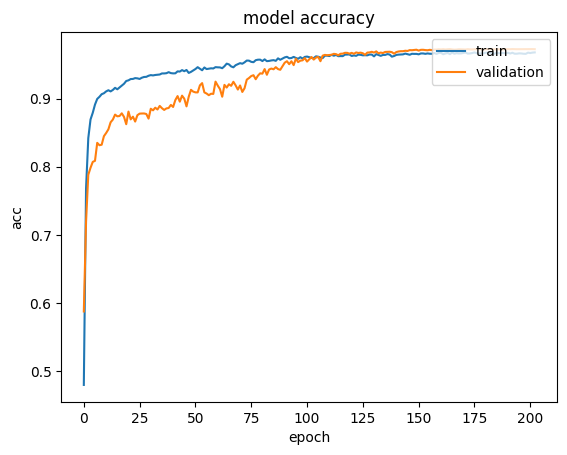

In [12]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [13]:
predictions = autoencoder.predict(X_val)
mse = np.mean(np.power(X_val - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val})
error_df.describe()

,reconstruction_error,true_class
count,28462.000000,28462.000000
mean,0.017726,0.001054
std,0.620148,0.032449
min,0.000032,0.000000
25%,0.000334,0.000000
50%,0.000698,0.000000
75%,0.001542,0.000000
max,32.396124,1.000000


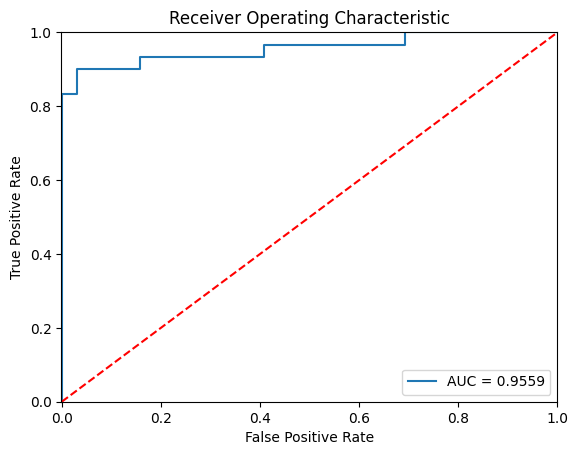

In [14]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


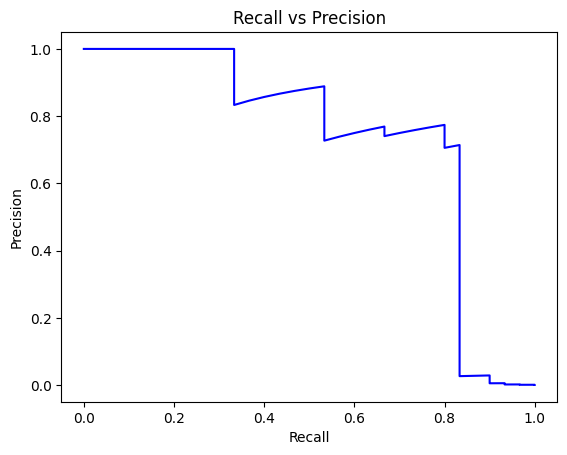

In [15]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

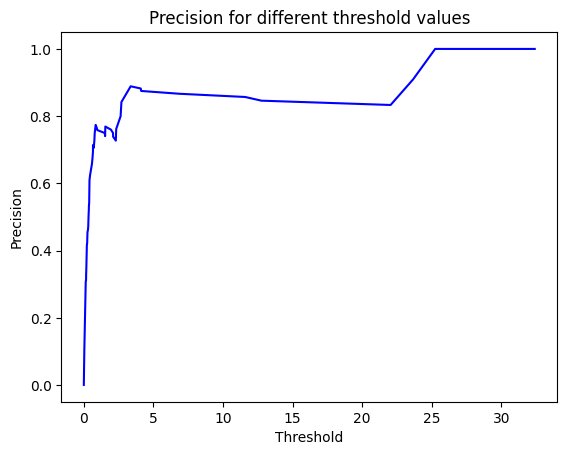

In [16]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

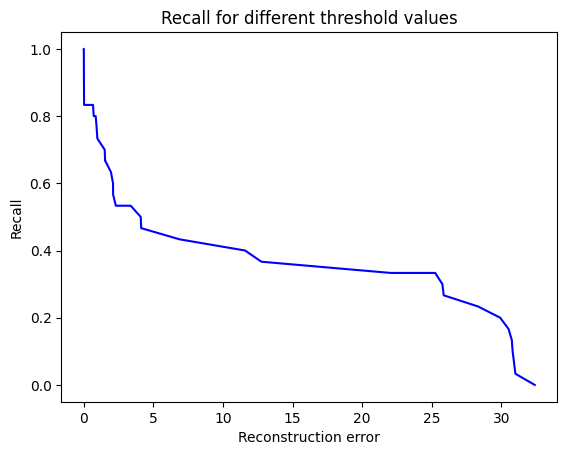

In [17]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

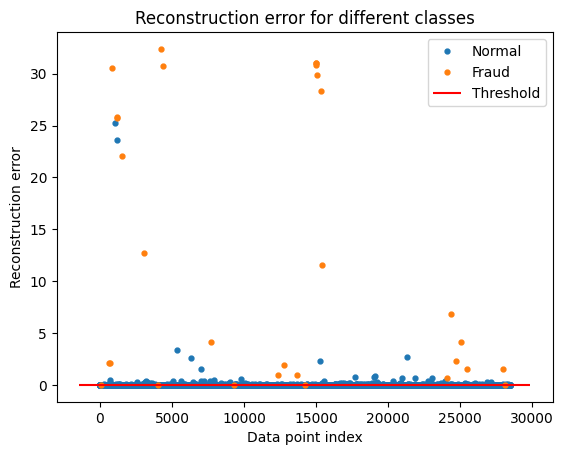

In [18]:
threshold = 0.037

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

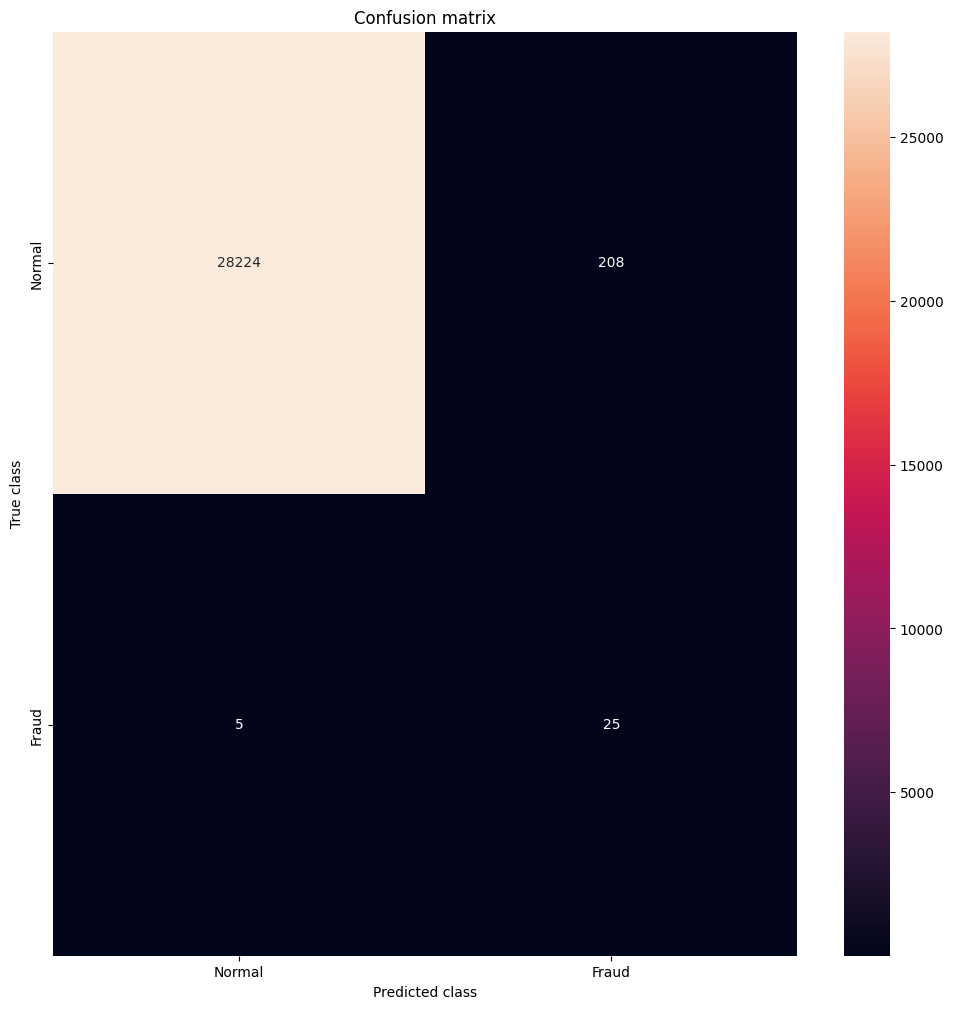

In [19]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

idx:  15  threshold:  0.009862273286328334 



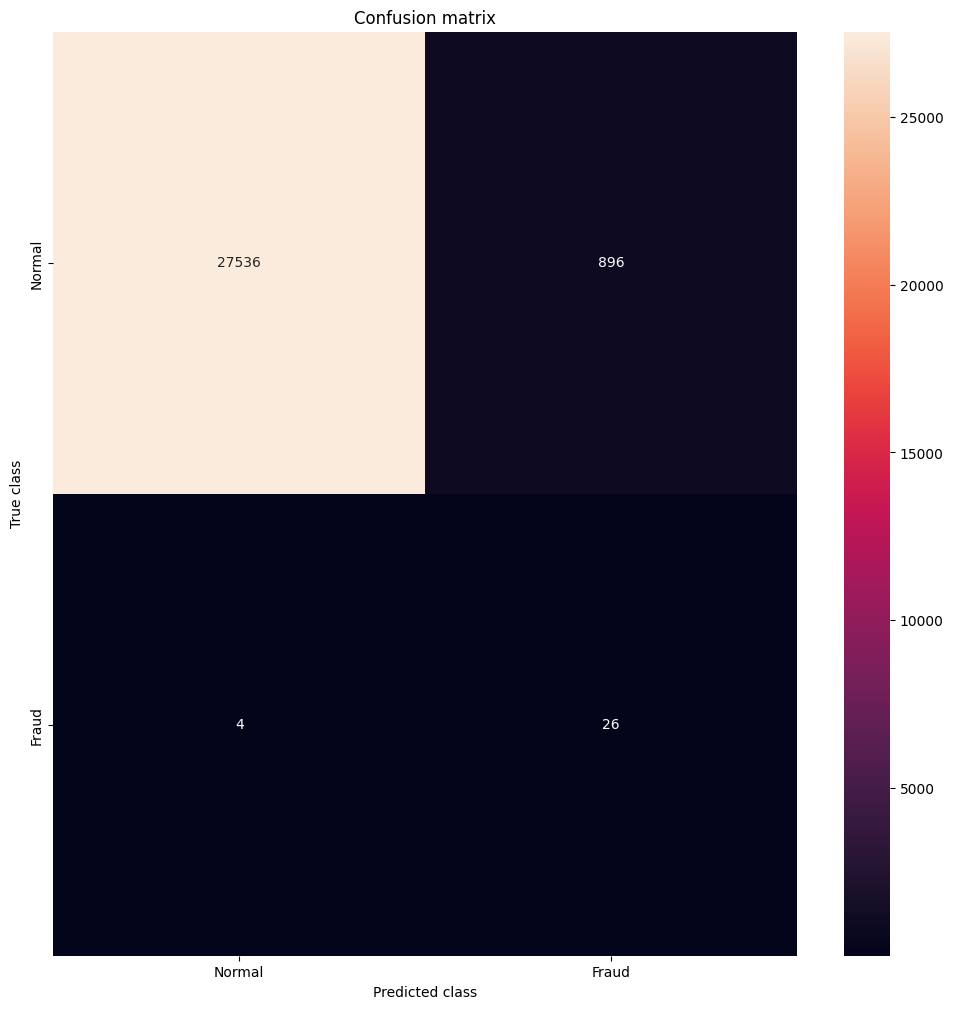

In [25]:
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx: ', optimal_idx, ' threshold: ', optimal_threshold, '\n')

y_pred_optimal = [1 if e > optimal_threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_optimal)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Inference

In [20]:
test_df = pd.read_csv('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/data/test.csv')
test_df = test_df.drop(columns=['ID'])

In [21]:
X_test = test_df.values

In [22]:
pred = autoencoder.predict(X_test)

In [26]:
def cos_sim(A,B):
    return dot(A,B)/(norm(A)*norm(B))


pred_list = []
cnt = 0
while cnt!=len(pred):
    cos = cos_sim(X_test[cnt], pred[cnt])
    if cos<optimal_threshold:
        pred_list.append(1)
    else:
        pred_list.append(0)
    cnt += 1


# Submission

In [27]:
submit = pd.read_csv('/Users/hanhyeongu/Desktop/HG/Dacon/Credit_fraud_detection/data/sample_submission.csv')
submit['Class'] = pred_list
submit.to_csv('./final2_autoencoder.csv', index=False)